# Proyecto el tapabocas

 # Objetivos del proyecto
El objetivo principal de este proyecto construir arquitecturas de red neuronales con el objetivo de clasificar imágenes de personas que tienen tapabocas o no. Para lograr esto, se realizará los siguientes pasos:
1. Construir la base de datos con imágenes de personas con  y sin tapabocas
2. Preprocesar los datos
3. Definir 3 arquitecturas de red neuronal
4. Evaluar el desempeño de cada una de las redes neuronales. 

In [4]:
import cv2
from skimage import data, color, io
from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from skimage import io

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
from skimage.metrics import structural_similarity as ssim
import pandas as pd

from tensorflow.keras import regularizers
%matplotlib inline


 A continuación implementaremos algunas funciones las cuales son necesarioas para poder realizar mas adelante la importación de los datos, limpiarlos y  por ultimo utilizarlos para las redes neuronales que se definan. Ademas, hacia la parte inferior se encuentra una función la cual sirve para graficar el error y el accuracy de los modelos.

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def load_data(path,w,h):
    """
    Crea la base de datos de las imagenes
    args:
        path: path de la carpeta con imagenes
        w: ancho de imagen
        h: alto de imagen
    returns:
        dataframe con registros de imagenes
    """
    names = os.listdir(path)
    width = w
    height = h
    data = np.zeros([len(names),width*height])
    for i in range(len(names)):
        image = io.imread(path+"/"+names[i], as_gray=True)
        image_resized = resize(image,(height , width),anti_aliasing=True)
        data[i,:] = np.asarray(image_resized).reshape(-1)
    data = pd.DataFrame(data,columns=[str(i) for i in range(width*height)])
    return data

def load_image(path,w,h):
    # Retorna una lista de imagenes que tienen el tamaño w,h
    names = os.listdir(path)
    width = w
    height = h
    data = []
    for i in range(len(names)):
        image = io.imread(path+"/"+names[i], as_gray=True)
        image_resized = resize(image,(height , width),anti_aliasing=True)
        data.append(image_resized)
    return data

def image_mean(data):
    # Retorna la imagen promedio de una base de imagenes
    mean = np.zeros(data[0].shape)
    for i in range(len(data)):
        mean += data[i]
    mean = mean/len(data)
    return mean

def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
    # show the images
    plt.show()
    
def get_mid_inf(data):
    data_inf = []
    h,w = data[0].shape
    for i in range(len(data)):
        data_inf.append(data[i][int((0.6*h)):int(0.85*h),int(0.25*w):int(0.83*w)])
    return data_inf

def get_mid_inf_foto(foto):
    h,w = foto.shape
    data = np.zeros([h,w])
    data = foto[int((0.6*h)):int(0.85*h),int(0.25*w):int(0.83*w)]
    return data

def trans_table(data):
    h,w = data[0].shape
    table = np.zeros([len(data),w*h])
    for i in range(len(data)):
        table[i,:] = np.asarray(data[i]).reshape(-1)
    table = pd.DataFrame(table,columns=[str(i) for i in range(w*h)])
    return table

def plot_model(epochs, history):
    fig2 = plt.figure(figsize=(20,30))
    fig2.subplots_adjust(wspace=0.2)

    values = range(1,epochs+1)
    loss_train = history.history['accuracy']
    loss_val = history.history['val_accuracy']
    ax = fig2.add_subplot(3,3,1) 
    ax.plot(values, loss_train, 'g', label='Training accuracy')
    ax.plot(values, loss_val, 'b', label='validation accuracy')
    ax.set_title('Training and Validation accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()

    ax = fig2.add_subplot(3,3,2) 
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    ax.plot(values, loss_train, 'g', label='Training Loss')
    ax.plot(values, loss_val, 'b', label='validation Loss')
    ax.set_title('Training and Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()
    
def cargar_foto(path):
    image = io.imread(path, as_gray=True)
    image_resized = resize(image,(128,72),anti_aliasing=True)
    return image_resized

## 1. Creacion de base de datos
A continuación, se importa un conjunto de fotos que fueron tomadas a diferentes personas. Hay que tener en cuenta que las fotos  conseguidas vienen recortadas tal que se encuadre sólo la cara de la persona con o sin tapabocas. Esto se hizo para reducir reducir el ruido de los datos tal que cuando las redes neuronales se entrenen se enfoquen unicamente en la cara y no en otros objetos. El conjunto de fotos conseguidas se distribuye de la siguiente manera:
1. Con tapabocas = 61
2. Sin tapabocas = 55

Para, importar los datos, se creó una función la cual carga las fotos en una lista. Por el momento, tomaremos esta lista para realizar un preprocesamiento previo a los datos antes de construir los modelos.

In [ ]:
# Revisar, BORRAR SI ES INNECESARIO
path_con = "C:/Users/urosario/OneDrive - Universidad del rosario/7 semestre/Aprendisaje de maquinas/ProyectoTapabocas/Fotos/con_tapabocas_recortado"
path_sin = "C:/Users/urosario/OneDrive - Universidad del rosario/7 semestre/Aprendisaje de maquinas/ProyectoTapabocas/Fotos/sin_tapabocas_recortado"
width = 72
height = 128
df_con = load_data(path_con,width,height)
df_sin = load_data(path_sin,width,height)

In [6]:
path_con = "./Fotos/con_tapabocas_recortado"
path_sin = "./Fotos/sin_tapabocas_recortado"
# Tamaño que se fija para todas las imagenes
width = 72
height = 128
list_con = load_image(path_con,width,height)
lists_sin = load_image(path_sin,width,height)

# Prueba de no realcion de datos



A continuación se obtiene la imagen promedio (en escala de grises) calculada para cada base de datos. Esto se realiza con el fin de conseguir una medida que nos permita distinguir si en efecto hay diferencia entre las imagenes con y sin tapabocas.

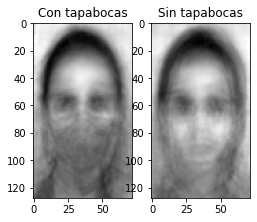

In [13]:
# Vamos a sacar la imagen promedio de cada lista de imagenes
mean_con = image_mean(list_con)
mean_sin = image_mean(lists_sin)
fig = plt.figure("Imagenes")
ax = fig.add_subplot(1,3,1)
ax.set_title("Con tapabocas")
plt.imshow(mean_con, cmap = plt.cm.gray)
fig = plt.figure("Imagenes")
ax = fig.add_subplot(1,3,2)
ax.set_title("Sin tapabocas")
plt.imshow(mean_sin, cmap = plt.cm.gray)
plt.show()

Vemos que las imagenes obtenidas no se ven muy bien puesto que cada una representa la imagen promedio de cada clase. Cabe mencionar que la mayoria de las imagenes que se encuentran en la base de conocimiento son mujeres por lo cual las imagenes promedio se ven similares a las de una mujer.. A continuación, se realiza una prueba de similitud sobre las imagenes ya que queremos confirmar si existe una diferencia suficiente para que se realice una buena clasificación.

Para comparar las dos imagenes se utilliza el indice estructural de similitud (SSIM por sus siglas en inglés)

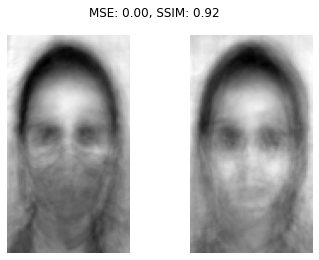

In [14]:
compare_images(mean_con,mean_sin,"Comparación")

Vemos que aunque el error cuadrático medio es 0 el indice de similitud estructural es de 0,92. Lo que indica que las imiagenes son de clases muy similares. Para mejorar esta diferencia se considera la sección de la imagen con tapabocas. 

 # Realizando prueba con los datos (solo parte inferior)

In [15]:
list_con_inf = get_mid_inf(list_con)
list_sin_inf = get_mid_inf(lists_sin)

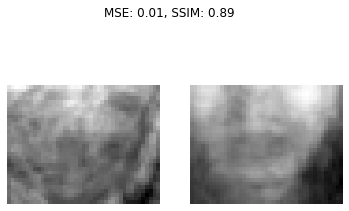

In [16]:
mean_list_con_inf = image_mean(list_con_inf)
mean_list_sin_inf = image_mean(list_sin_inf)
compare_images(mean_list_con_inf,mean_list_sin_inf,"Mitad inferior")

Vemos que aunque la similitud entre las dos imagenes sigue siendo alta disminuye el valor del SSIM. 

 ## Transformación de imagen a tabla de datos
 
Se transforman las imágenes a arreglos de una dimensión (en este caso con 128 $\times$ 72 = 1312 valores). Esta es la dimensión de los datos de entrada para las redes neuronales propuestas.

In [19]:
# Tabla de datos con tapabocas
table_con = trans_table(list_con_inf)
# Tabla de datos sin tapabocas
table_sin = trans_table(list_sin_inf)

In [20]:
# Crando el dataset con todos los datos, con tapabocas y sin.
# Agregar la columna de etiquetas (1: con tapabocas y 0: sin tapabocas)
print(table_con.shape)
print(table_sin.shape)
df = pd.DataFrame(np.concatenate([table_con,table_sin],axis=0), columns = table_con.columns)
df["mask_on"] = np.array(["1"]*table_con.shape[0] + ["0"]*table_sin.shape[0])
df["mask_on"] = pd.get_dummies(df["mask_on"],drop_first=True)
df = df.sample(frac=1)

(61, 1312)
(55, 1312)


In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1303,1304,1305,1306,1307,1308,1309,1310,1311,mask_on
40,0.093670,0.124247,0.140639,0.142240,0.143680,0.149335,0.155504,0.154850,0.151997,0.149021,...,0.475530,0.483721,0.488860,0.474130,0.368715,0.165402,0.140307,0.142267,0.127726,1
90,0.627496,0.650128,0.668658,0.675000,0.680330,0.687200,0.698584,0.712223,0.708342,0.688668,...,0.292106,0.243763,0.213319,0.194169,0.181499,0.166189,0.155631,0.160539,0.169739,0
7,0.867489,0.859231,0.864953,0.863597,0.868893,0.873145,0.878903,0.884097,0.892719,0.899694,...,0.673955,0.674812,0.673300,0.677904,0.698608,0.631061,0.468620,0.563648,0.489666,1
98,0.576726,0.607341,0.728023,0.801412,0.837373,0.811017,0.773748,0.752478,0.757313,0.775913,...,0.535503,0.534187,0.545041,0.568156,0.569820,0.566092,0.534750,0.483273,0.464323,0
83,0.369898,0.406534,0.431150,0.428050,0.456003,0.503558,0.534998,0.559212,0.555002,0.559329,...,0.676927,0.673785,0.619673,0.626592,0.392945,0.203735,0.175179,0.259462,0.306339,0


----

## 2. Definición de las arquitecturas de red probadas

### Separación de datos de entrenamiento y de prueba

In [22]:
# Inicializando los parametros de la red neuronal
from keras import models
from keras import layers
from keras.layers import LeakyReLU
from keras.utils.np_utils import to_categorical

In [23]:
X = df.iloc[:,:-1]
y = df["mask_on"]
aux = pd.get_dummies(y, drop_first=True)
print(aux)
#y = to_categorical(y,num_classes=2)
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,aux,test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

     1
40   1
90   0
7    1
98   0
83   0
..  ..
71   0
74   0
108  0
68   0
17   1

[116 rows x 1 columns]


### Arquitectura 1: decrecimiento de neuronas por capa

In [25]:

network = models.Sequential()
network.add(layers.Dense(1312, activation='sigmoid', input_shape=(1312,)))
network.add(layers.Dense(300,activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
network.add(layers.Dense(200,activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
network.add(layers.Dense(100,activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
network.add(layers.Dense(50,activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
network.add(layers.Dense(2,activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
network.compile(optimizer = 'rmsprop',
                loss='categorical_crossentropy',
               metrics=['accuracy'])

### Arquitectura 2: Mismo número de neuronas por capa

In [26]:
network2 = models.Sequential()
network2.add(layers.Dense(1312, activation='relu', input_shape=(1312,)))
network2.add(layers.Dense(1312,activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
network2.add(layers.Dense(1312,activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
network2.add(layers.Dense(1312,activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
network2.add(layers.Dense(2,activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
network2.compile(optimizer = 'rmsprop',
                loss='categorical_crossentropy',
               metrics=['accuracy'])

### Arquitectura 3: crecimiento y decrecimiento de neuronas por capa

In [28]:
network3 = models.Sequential()
network3.add(layers.Dense(1312, activation='sigmoid', input_shape=(1312,)))
network3.add(layers.Dense(1300,activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
network3.add(layers.Dense(1500,activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
network3.add(layers.Dense(2,activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
network3.compile(optimizer = 'rmsprop',
                loss='categorical_crossentropy',
               metrics=['accuracy'])

In [29]:

y_train_categorical = to_categorical(y_train)
y_val_cateforical = to_categorical(y_val)
history = network.fit(X_train, y_train_categorical,validation_data=(X_val,y_val_cateforical), epochs=100, batch_size = 10)

Epoch 1/100
7/7 [==============================] - 1s 164ms/step - loss: 0.7756 - accuracy: 0.4493 - val_loss: 0.7569 - val_accuracy: 0.6957
Epoch 2/100
7/7 [==============================] - 0s 59ms/step - loss: 0.7565 - accuracy: 0.5797 - val_loss: 0.7381 - val_accuracy: 0.5652
Epoch 3/100
7/7 [==============================] - 0s 65ms/step - loss: 0.7423 - accuracy: 0.5072 - val_loss: 0.7363 - val_accuracy: 0.6957
Epoch 4/100
7/7 [==============================] - 1s 74ms/step - loss: 0.7256 - accuracy: 0.5942 - val_loss: 0.7327 - val_accuracy: 0.6087
Epoch 5/100
7/7 [==============================] - 1s 77ms/step - loss: 0.7107 - accuracy: 0.6377 - val_loss: 0.7349 - val_accuracy: 0.4348
Epoch 6/100
7/7 [==============================] - 0s 67ms/step - loss: 0.6750 - accuracy: 0.6232 - val_loss: 0.6922 - val_accuracy: 0.6957
Epoch 7/100
7/7 [==============================] - 0s 64ms/step - loss: 0.6440 - accuracy: 0.6957 - val_loss: 0.6264 - val_accuracy: 0.6957
Epoch 8/100
7/7 [==

7/7 [==============================] - 1s 73ms/step - loss: 0.5515 - accuracy: 0.6957 - val_loss: 0.8297 - val_accuracy: 0.4348
Epoch 60/100
7/7 [==============================] - 1s 74ms/step - loss: 0.5106 - accuracy: 0.7681 - val_loss: 0.5724 - val_accuracy: 0.6522
Epoch 61/100
7/7 [==============================] - 0s 63ms/step - loss: 0.4678 - accuracy: 0.7971 - val_loss: 0.6670 - val_accuracy: 0.6522
Epoch 62/100
7/7 [==============================] - 0s 62ms/step - loss: 0.4567 - accuracy: 0.7971 - val_loss: 0.6683 - val_accuracy: 0.6522
Epoch 63/100
7/7 [==============================] - 0s 60ms/step - loss: 0.4575 - accuracy: 0.7971 - val_loss: 0.6664 - val_accuracy: 0.6522
Epoch 64/100
7/7 [==============================] - 0s 58ms/step - loss: 0.4562 - accuracy: 0.7971 - val_loss: 0.6537 - val_accuracy: 0.6522
Epoch 65/100
7/7 [==============================] - 0s 62ms/step - loss: 0.4527 - accuracy: 0.7971 - val_loss: 0.7074 - val_accuracy: 0.6957
Epoch 66/100
7/7 [========

Vemos que el accuracy para la primera red oscila entre 0.43 y 0.45.

In [30]:
# Entrenamiento para la red 2
history2 = network2.fit(X_train, y_train_categorical,validation_data=(X_val,y_val_cateforical), epochs=70, batch_size = 10)

Epoch 1/70
7/7 [==============================] - 2s 246ms/step - loss: 7.4220 - accuracy: 0.4783 - val_loss: 7.2498 - val_accuracy: 0.5652
Epoch 2/70
7/7 [==============================] - 1s 152ms/step - loss: 8.1542 - accuracy: 0.5072 - val_loss: 7.1851 - val_accuracy: 0.5652
Epoch 3/70
7/7 [==============================] - 1s 175ms/step - loss: 8.1003 - accuracy: 0.5072 - val_loss: 7.1425 - val_accuracy: 0.5652
Epoch 4/70
7/7 [==============================] - 1s 177ms/step - loss: 8.0631 - accuracy: 0.5072 - val_loss: 7.1116 - val_accuracy: 0.5652
Epoch 5/70
7/7 [==============================] - 1s 178ms/step - loss: 8.0355 - accuracy: 0.5072 - val_loss: 7.0880 - val_accuracy: 0.5652
Epoch 6/70
7/7 [==============================] - 1s 165ms/step - loss: 8.0144 - accuracy: 0.5072 - val_loss: 7.0697 - val_accuracy: 0.5652
Epoch 7/70
7/7 [==============================] - 1s 190ms/step - loss: 7.9976 - accuracy: 0.5072 - val_loss: 7.0548 - val_accuracy: 0.5652
Epoch 8/70
7/7 [====

7/7 [==============================] - 1s 179ms/step - loss: 7.9424 - accuracy: 0.5072 - val_loss: 7.0081 - val_accuracy: 0.5652
Epoch 60/70
7/7 [==============================] - 1s 170ms/step - loss: 7.9424 - accuracy: 0.5072 - val_loss: 7.0080 - val_accuracy: 0.5652
Epoch 61/70
7/7 [==============================] - 1s 164ms/step - loss: 7.9425 - accuracy: 0.5072 - val_loss: 7.0080 - val_accuracy: 0.5652
Epoch 62/70
7/7 [==============================] - 1s 162ms/step - loss: 7.9424 - accuracy: 0.5072 - val_loss: 7.0080 - val_accuracy: 0.5652
Epoch 63/70
7/7 [==============================] - 1s 165ms/step - loss: 7.9424 - accuracy: 0.5072 - val_loss: 7.0080 - val_accuracy: 0.5652
Epoch 64/70
7/7 [==============================] - 1s 161ms/step - loss: 7.9425 - accuracy: 0.5072 - val_loss: 7.0081 - val_accuracy: 0.5652
Epoch 65/70
7/7 [==============================] - 1s 166ms/step - loss: 7.9424 - accuracy: 0.5072 - val_loss: 7.0080 - val_accuracy: 0.5652
Epoch 66/70
7/7 [========

Para la segunda red el accuracy se mantiene igual en todas las época y es igual a 0.57.

In [31]:
# Entrenamiento para la red 3
history3 = network3.fit(X_train, y_train_categorical,validation_data=(X_val,y_val_cateforical), epochs=50, batch_size = 10)

Epoch 1/50
7/7 [==============================] - 1s 188ms/step - loss: 2.9726 - accuracy: 0.4928 - val_loss: 0.9693 - val_accuracy: 0.4348
Epoch 2/50
7/7 [==============================] - 1s 127ms/step - loss: 0.9523 - accuracy: 0.4928 - val_loss: 0.9440 - val_accuracy: 0.4348
Epoch 3/50
7/7 [==============================] - 1s 129ms/step - loss: 0.9373 - accuracy: 0.4928 - val_loss: 0.9338 - val_accuracy: 0.4348
Epoch 4/50
7/7 [==============================] - 1s 138ms/step - loss: 0.9286 - accuracy: 0.4928 - val_loss: 0.9189 - val_accuracy: 0.4348
Epoch 5/50
7/7 [==============================] - 1s 140ms/step - loss: 0.9109 - accuracy: 0.4928 - val_loss: 0.9080 - val_accuracy: 0.4348
Epoch 6/50
7/7 [==============================] - 1s 153ms/step - loss: 0.8988 - accuracy: 0.4638 - val_loss: 0.8883 - val_accuracy: 0.5217
Epoch 7/50
7/7 [==============================] - 1s 132ms/step - loss: 0.8808 - accuracy: 0.5652 - val_loss: 0.8699 - val_accuracy: 0.6522
Epoch 8/50
7/7 [====

## 3. Escoger la red con mejor desempeño
A continuación se muestran graficas del accuracy y el Loss para los datos de entrenamiento y de validación.

El accuracy para la red neuronal 3 es varía entre 0.43 y 0.7.

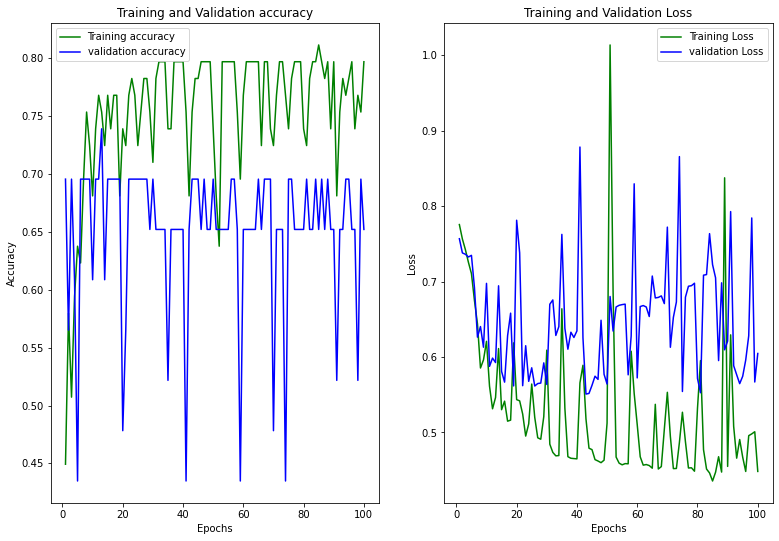

In [32]:
plot_model(100,history)

Vemos que para la primera red el mejor accuracy con los datos de entrenamiento se obtiene alrededor de 85 épocas.

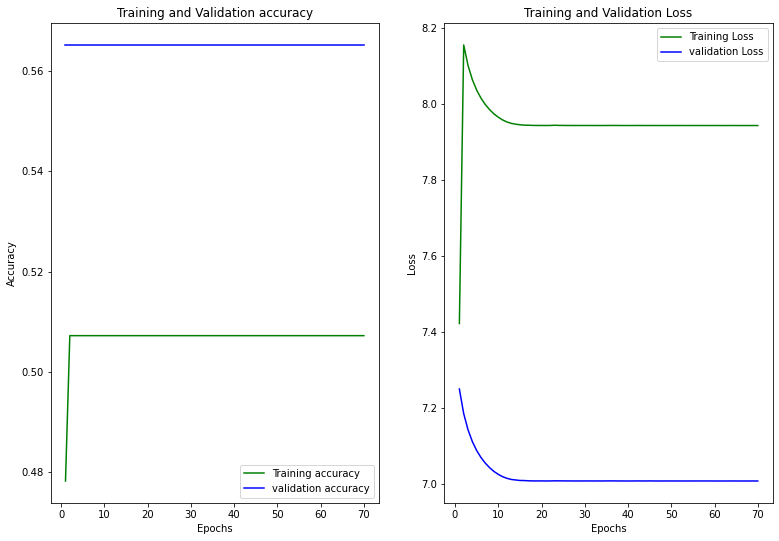

In [35]:
plot_model(70,history2)

Vemos que para la segunda red el accuracy permaneció igual en practicamente todas las épocas. Al parecer este tipo de arquitectura no es la adecuada para clasificar las imágenes conseguidas. 

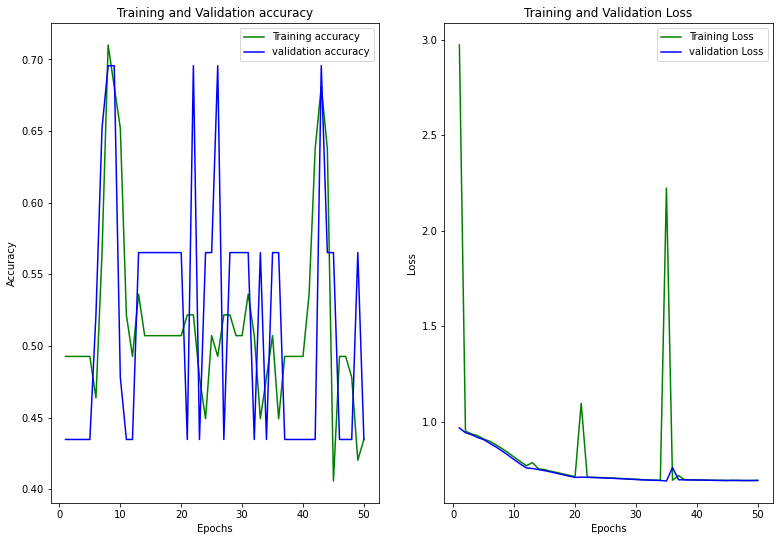

In [34]:
plot_model(50,history3)

Vemos que para la 3era red hay un buen entrenamiento porque el training loss sigue una tendencia decreciente hasta aproximadamente 0.4.

Al comparar el accuracy de la primera red con la 3era parece que la mejor red es la primera ya que fue la que en una época determinada tiene el accuracy más alto.

## 4. Prueba rendimiento de redes (con conjunto de datos de prueba)

In [37]:
# Para la red 1 
y_test_categorical = to_categorical(y_test)
test_loss, test_acc = network.evaluate(X_test,y_test_categorical)
print(test_acc)

1/1 [==============================] - 0s 2ms/step - loss: 0.7646 - accuracy: 0.6250
0.625


In [38]:
# Para la red 2
test_loss2, test_acc2 = network2.evaluate(X_test,y_test_categorical)
print(test_acc2)

1/1 [==============================] - 0s 4ms/step - loss: 7.3876 - accuracy: 0.5417
0.5416666865348816


In [39]:
# Para la red 3
test_loss3, test_acc3 = network3.evaluate(X_test,y_test_categorical)
print(test_acc3)

1/1 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4583
0.4583333432674408


Al comprobar con un dato de entrenamiento vemos que en efecto la mejor arquitectura de red es como la primera en la que el número de neuronas disminuye por capa.

# Preguntas
1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?\
**Respuesta:** Aunque el accuracy de la primera red parece muy inestable es la que mejor muestra resultados para clasificación. También se puede afirmar que las redes se ejecutan rapido ya que se redujo considerablemente el tamaño original de las imagenes sin que perdieran su resolucion.
2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?\
**Respuesta:** Para seleccionar la arquitectura de la red se usaron 2 métricas: el accuracy y el Loss tanto para los datos de entrenamiento como los de validación.
3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?\
**Respuesta:** Por un lado, laas redes 2 y 3 no muestran los resultados esperados. Se cree que este comportamiento se debe a que introducir más neuronas o dejar las misma cantidad por capa no agrega información para que la red aprenda la estructura de los datos ingresados.  Por otro lado, la primera sí ya que a medida que aumentan las épocas en general el accuracy aumenta también.
4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?\
**Respuesta:** Por un lado conseguiría fotos más variadas, de personas con color de piel distinto y en mismo número de mujeres uy de hombres. Esto con el objetivo de que el modelo sea más general y también produzca buenos resultados con personas de distintas caracteristicas. Por otro lado, una vez conseguida una buena base de datos ,exploraría un número de capas y de neuronas por capa óptimo para mejorar la presición de la arquitectura.
